In [195]:
%matplotlib inline  
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time
import googlemaps
import requests
import responses
import json
from functools import partial

In [8]:
df = pd.read_csv('analyze_me.csv')

In [9]:
df.head()

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44.541717,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,40.738868,-74.002747,40.751257,-74.005634,2014-10-30 10:54:11.531894,2014-10-30 11:04:17.759577,2014-10-30 11:16:37.895816,2014-10-30 11:32:38.090061
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45.035418,40.726110,-74.002492,40.709323,-74.015867,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595


In [55]:
#Number of Null or missing values by column
df.isnull().sum()

delivery_id                               0
customer_id                               0
jumpman_id                                0
vehicle_type                              0
pickup_place                              0
place_category                          883
item_name                              1230
item_quantity                          1230
item_category_name                     1230
how_long_it_took_to_order              2945
pickup_lat                                0
pickup_lon                                0
dropoff_lat                               0
dropoff_lon                               0
when_the_delivery_started                 0
when_the_Jumpman_arrived_at_pickup      550
when_the_Jumpman_left_pickup            550
when_the_Jumpman_arrived_at_dropoff       0
dtype: int64

### Hypothesis 1. 
item_name, item_quantity, and item_category_name: the number null values line up, which makes me suspect there's some correlation between these values. Further, I suspect several pickup_place are disproportionately responsible for missing menu items.  

In [110]:
#Get a subset of the original datafram where item_name, item_quantity, and item_category_name are null for each row. If the sum of the unique delivery ids match up, we know that if one of these fields is null, then the rest are also null.
item_names_na = df[(df['item_name'].isnull() == True) & (df['item_quantity'].isnull() == True) & (df['item_category_name'].isnull() == True)]

if item_names_na['delivery_id'].count() == df[df['item_name'].isnull() == True]['delivery_id'].count():
    print('The events item_name, item_quantity, and item_category always occur together')

The events item_name, item_quantity, and item_category always occur together


In [126]:
nullItemsByPickup = item_names_na.groupby(['pickup_place'])['delivery_id'].count().reset_index().sort_values('delivery_id', ascending=False)
nullItemsByPickup.head()

,pickup_place,delivery_id
169,Duane Reade,64
132,Chipotle Mexican Grill $1.99 Delivery,56
399,Philippe Chow,24
483,Starbucks,23
330,McDonald's,19


In [128]:
nullItemsByPickup.describe()

,delivery_id
count,592.000000
mean,2.077703
std,4.158132
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,64.000000


In [146]:
def findTotalDeliveries(pickup_place):
    #Finding the total number of deliveries given a restaurant
    return(df[df['pickup_place'] == pickup_place]['delivery_id'].count())

#Use apply findTotalDeliveries to find all the deliveries associated with the restaurants having null item values
nullItemsByPickup['total_restaurant_deliveries'] = nullItemsByPickup['pickup_place'].apply(findTotalDeliveries)

#How many total locations have this issue?
pickupPlace = nullItemsByPickup['pickup_place'].count()
pickupPlace100 = nullItemsByPickup[nullItemsByPickup['delivery_id'] == nullItemsByPickup['total_restaurant_deliveries']]['delivery_id'].count()
print(pickupPlace,"pickup_place have missing menu items from the Jumpman23 system")

#How many of the locations having the missing menu item issue have it 100% of the time?
print(pickupPlace100,"pickup_place have missing menu items from the Jumpman23 system 100% of the time")

print(pickupPlace100/pickupPlace*100, "%", " of pickup_place experience this issue 100% of the time")

592 pickup_place have missing menu items from the Jumpman23 system
518 pickup_place have missing menu items from the Jumpman23 system 100% of the time
87.5 %  of pickup_place experience this issue 100% of the time


Through this analysis, we've identified a strong possibility that many restaurants have missing menu items in the Jumpman23 system.

### Hypothesis 2. : null values in when_the_Jumpman_arrived_at_pickup and when_the_Jumpman_left_pickup. 

The Jumpman23 app tracks the delivery process to ensure everything is going smoothly. Once the user's mobile device is sufficiently close to the pickup location (coordinates), the app records the arrival time. Similarly, when the Jumpman leaves the pickup location for to complete the delivery, the app records the departure time. 

I'd like to explore three possibilities:

1. The Jumpman23 app isn't functioning properly for some device types - somehow the GPS is failing where. If true, we'd expect to see Jump(wo)men with disproportionately high instances of null arrival and departure pickup location times.

2. The restaurant pickup_place coordinates are incorrect in our databases. For this result to be true, we'd expect to see some pickup_place exhibit high numbers of null values for the arrival and departure times.

In [139]:
nullPickupTime = df[(df['when_the_Jumpman_arrived_at_pickup'].isnull() == True) & (df['when_the_Jumpman_arrived_at_pickup'].isnull() ==True)]

if nullPickupTime['delivery_id'].count() == df[(df['when_the_Jumpman_arrived_at_pickup'].isnull() == True)]['delivery_id'].count():
    print('The events when_the_Jumpman_arrived_at_pickup and when_the_Jumpman_arrived_at_pickup always occur together') 

The events when_the_Jumpman_arrived_at_pickup and when_the_Jumpman_arrived_at_pickup always occur together


In [155]:
nullPickupTimeByJumpman = nullPickupTime[['jumpman_id','delivery_id']].groupby('jumpman_id').count().reset_index().sort_values('delivery_id', ascending=False)

def findTotalJumpmanDeliveries(jumpman_id):
    #Finding the total number of deliveries given a restaurant
    return(df[df['jumpman_id'] == jumpman_id]['delivery_id'].count())

nullPickupTimeByJumpman['jumpman_total'] = nullPickupTimeByJumpman['jumpman_id'].apply(findTotalJumpmanDeliveries)
nullPickupTimeByJumpman['pct'] = nullPickupTimeByJumpman['delivery_id']/nullPickupTimeByJumpman['jumpman_total']
nullPickupTimeByJumpman.head()

,jumpman_id,delivery_id,jumpman_total,pct
74,66416,15,62,0.241935
66,61900,12,61,0.196721
51,53095,9,50,0.180000
177,142394,9,73,0.123288
98,99219,8,78,0.102564


In [157]:
nullPickupTimeByJumpman.describe()

,jumpman_id,delivery_id,jumpman_total,pct
count,253.000000,253.000000,253.000000,253.000000
mean,104735.498024,2.173913,16.664032,0.224127
std,50043.143966,1.869076,14.519342,0.228503
min,3296.000000,1.000000,1.000000,0.017857
25%,60891.000000,1.000000,6.000000,0.083333
50%,115756.000000,2.000000,13.000000,0.142857
75%,147789.000000,2.000000,21.000000,0.250000
max,178325.000000,15.000000,78.000000,1.000000


In [164]:
df.jumpman_id.nunique()

578

In [153]:
nullPickupTimeByPickup = nullPickupTime[['pickup_place','delivery_id']].groupby('pickup_place').count().reset_index().sort_values('delivery_id', ascending=False)

nullPickupTimeByPickup['pickup_place_total'] = nullPickupTimeByPickup['pickup_place'].apply(findTotalDeliveries)
nullPickupTimeByPickup.head()

,pickup_place,delivery_id,pickup_place_total
30,Blue Ribbon Sushi,24,151
192,Whole Foods Market,22,119
155,Shake Shack,22,311
112,McDonald's,21,62
53,Duane Reade,20,64


# Data cleaning

In [235]:
def convertToSeconds(timestr):
    #converts time string into seconds
    timestr
    ftr = [3600,60,1]
    try:
        return sum([a*b for a,b in zip(ftr, map(float,timestr.split(':')))])
    except: 
        pass
    
def calculateDistance(lat1,lon1,lat2,lon2):
    #calculates the distance in miles
    start_coord = (lat1,lon1)
    end_coord = (lat2,lon2)
    return(vincenty(start_coord,end_coord).miles)
    

In [36]:
#Let's convert all our timestamps into proper datetimes. 
for column in df[['when_the_delivery_started','when_the_Jumpman_arrived_at_pickup','when_the_Jumpman_left_pickup','when_the_Jumpman_arrived_at_dropoff']].dropna():
    df[column] = df[column].apply(pd.to_datetime)

for column in df[['when_the_delivery_started','when_the_Jumpman_arrived_at_pickup','when_the_Jumpman_left_pickup','when_the_Jumpman_arrived_at_dropoff']]:
    print(df[column].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


# Analysis
To remain competitive in the industry, Jumpman23 effectively needs to build a strong userbase on both sides of the delivery marketplace. This means ensuring speedy deliveries and creating value for Jumpmen. We'll first look at the overall delivery experience, then look at how Jumpmen use the system.

## 1. Delivery User Experience

Nobody like to eat cold McDonalds fries. Nor do Jumpman23's users. Thus, optimizing the Jumpman23 delivery experience should focus on these fundamental research questions:

#### Research questions:

1. How long do customers have to wait before receiving their delivery? 
2. What variables impact Jumpman23's delivery time?
3. What 

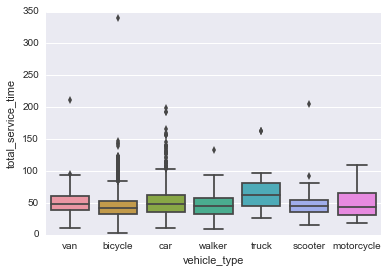

In [243]:
ax = sns.boxplot(x='vehicle_type', y='total_service_time', data=df[['vehicle_type','total_service_time']])

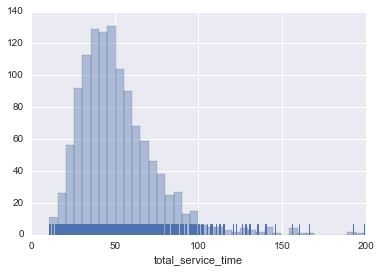

In [244]:
sns.distplot(df[df['vehicle_type'] == 'car']['total_service_time'], kde=False, rug=True)

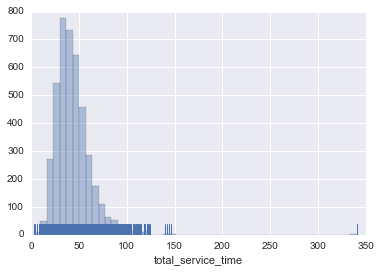

In [284]:
sns.distplot(df[df['vehicle_type'] == 'bicycle']['total_service_time'], kde=False, rug=True)

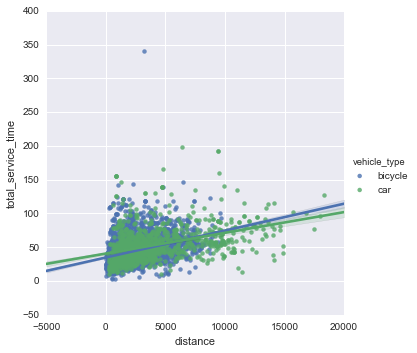

In [285]:
sns.lmplot(x="distance", y="total_service_time", hue="vehicle_type", data=df[['total_service_time','distance','vehicle_type']][(df['vehicle_type'] == 'bicycle') | (df['vehicle_type'] == 'car')]);

## 2. Jumpman23 Experience

Jump(wo)men are in the business of being profitable. Both their time and their effort should be rewarded financially. The great thing is that Jumpman23's incentives are aligned with our Jump(wo)men. The more valuable deliveries they can make, the more successful we are.

#### Assumptions:
1. Jump(wo)men revenue per trip is a function of milage, time, and some flat rate
2. Jump(wo)men are only paid for the milage from the pickup_place to the dropoff place.
3. Jump(wo)men are only paid for the time between the the delivery from when_the_delivery_started to when_the_Jumpman_arrived_at_dropoff

#### Research questions:

1. How far do Jumpmen have to travel per delivery?
2. How many trips can Jumpmen do in a day?

### How far do Jumpmen have to travel per delivery?
The good news is that we have all our longitudinal and latitudinal data.
Calculating the straight line between the pickup coordinates and the dropoff coordinates is insufficient and unreliable, since it doesn't take into account for any detours the Jumo(wo)men might have to take. In reality, Jump(wo)men also face different traffic and weather conditions. 

In [233]:
#Conncet to Google Maps Direction API
gmaps = googlemaps.Client('REDACTED')

def calcDistance(mode,lat1,lon1,lat2,lon2):
    #API calls to find distance and time based on best route accoriding to Google Maps
    origins = [lat1,lon1]
    destinations = [lat2,lon2]
    directions = gmaps.directions(origins, destinations, mode=mode, units='metric')
    try:
        directions[0]['legs'][0]['distance']['value']
        distance = directions[0]['legs'][0]['distance']['value']
    except:
        distance = float('NaN')
    try:
        directions[0]['legs'][0]['distance']['value']
        time = directions[0]['legs'][0]['duration']['value']
    except:
        time = float('NaN')
    return (distance, time)

def travelModes(type):
    if type in ['van', 'car', 'truck', 'scooter', 'motorcycle']:
        return('driving')
    elif type == 'bicycle':
        return('bicycling')
    else:
        return('walking')

In [234]:
#Get API data on distance and predicted time
distance = []
time = []
for index, row in df.iterrows():
    rowdistance, rowtime = calcDistance(travelModes(row['vehicle_type']), row['pickup_lat'], row['pickup_lon'], row['dropoff_lat'], row['dropoff_lon'])
    distance.append(rowdistance)
    time.append(rowtime)
df['distance'] = pd.Series(distance).values
df['time'] = pd.Series(time).values    

In [242]:
df[['distance','time']].describe()

,distance,time
count,5982.000000,5982.000000
mean,2613.293213,651.803243
std,2205.773935,517.816344
min,9.000000,3.000000
25%,1173.000000,318.250000
50%,1983.000000,525.000000
75%,3314.000000,851.000000
max,18299.000000,7954.000000


In [281]:
def totalTime(x):
    return(x.total_seconds()/60)

df['total_service_time'] = df['when_the_Jumpman_arrived_at_dropoff'] - df['when_the_delivery_started']
df['total_service_time'] = df['total_service_time'].apply(totalTime)

df['speed'] = (df['distance']/1000)/(df['time']/3600)

Is the API data useful in predicting delivery time? If we graph the total service time against the Google Maps API data, e can see there's a strong correlation between the API times and the actual service times.

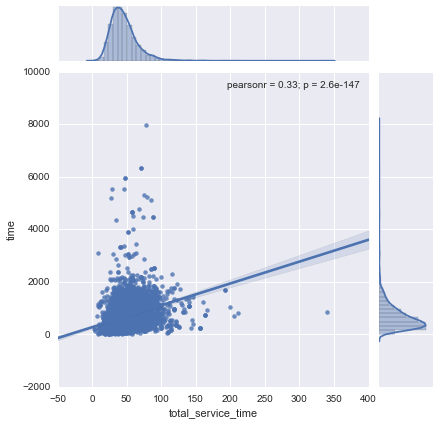

In [264]:
sns.jointplot("total_service_time", "time", data=df[['total_service_time','time']].dropna(), kind="reg")

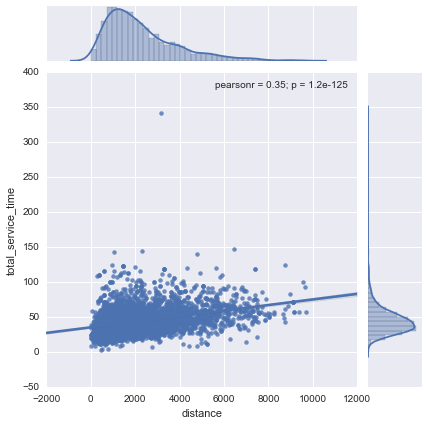

In [282]:
sns.jointplot("distance", "total_service_time", data=df[['total_service_time','distance']][df['vehicle_type'] == 'bicycle'].dropna(), kind="reg")

In [246]:
df['just_date'] = df['when_the_delivery_started'].dt.date
df['weekday'] = df['when_the_delivery_started'].dt.dayofweek

/Users/joshchua/anaconda/envs/snakes/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning:

invalid value encountered in greater_equal

/Users/joshchua/anaconda/envs/snakes/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning:

invalid value encountered in less_equal



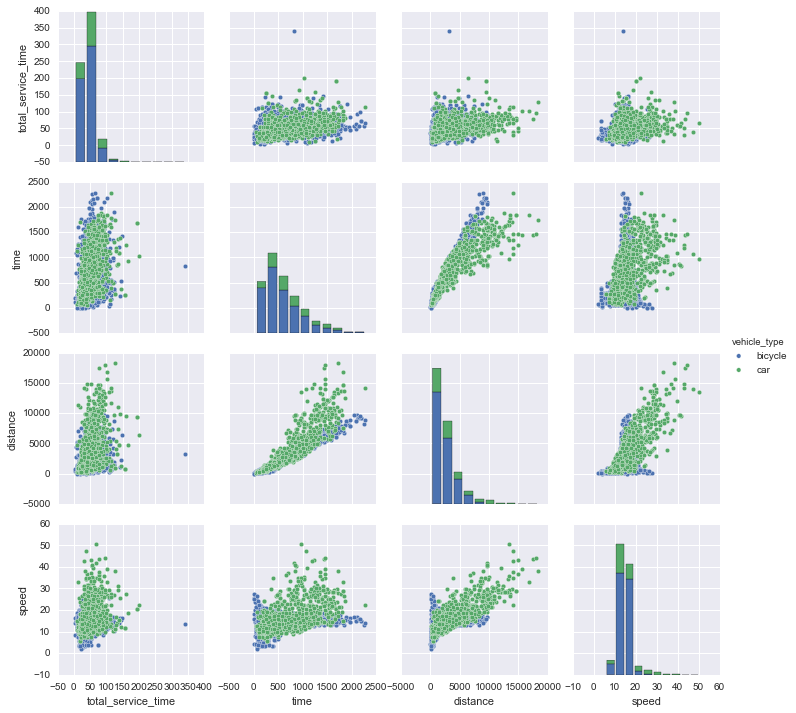

In [280]:
sns.pairplot(df[['total_service_time','time','distance','vehicle_type','speed']][(df['vehicle_type'] == 'bicycle') | (df['vehicle_type'] == 'car')], hue="vehicle_type")

A few observations: Is there a difference in Jump(wo)men performance based on vehicle type? 
- From the bottom left corner: Unsurprisingly, cars seem to be more willing to take on jobs that are farther away. This may explain the higher average car total_service_time
- The graph of distance vs time for the bicycle data points seems suspiciously linear. This may uncover some unique considerations in using the Google Maps API


In [278]:
df[['vehicle_type','total_service_time']].groupby(['vehicle_type']).mean().reset_index()

,vehicle_type,total_service_time
0,bicycle,44.017813
1,car,52.030971
2,motorcycle,47.082782
3,scooter,47.378933
4,truck,65.718805
5,van,50.433628
6,walker,46.804036
